# Preparing a proposal

The Story: Suppose that you are preparing to write a proposal on NGC1365, aiming to investigate the intriguing black hole spin this galaxy with Chandra grating observations (see: https://www.space.com/19980-monster-black-hole-spin-discovery.html ) 

In writing proposals, there are often the same tasks that are required: including finding and analyzing previous observations of the proposal, and creating figures that include, e.g., multiwavelength images and spectrum for the source. 


In [1]:
# As a hint, we include the code block for Python modules that you will likely need to import:   
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

# For downloading files
from astropy.utils.data import download_file
from astropy.io import fits

import pyvo as vo

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

### Step 1: Find out what the previously quoted Chandra 2-10 keV flux of the central source is for NGC 1365.  

Hint: Do a table access protocol (TAP) search in the heasarc, to find potential table with this information

In [2]:
#  This gets all services matching, which should be a list of only one:
tap_services=vo.regsearch(servicetype='table',keywords=['heasarc'])
#  This fetches the list of tables that this service serves:
heasarc_tables=tap_services[0].service.tables

In [3]:
for tablename in heasarc_tables.keys():
    if "chanmas" in tablename:  
        print("Table {} has columns={}\n".format(
            tablename,
            sorted([k.name for k in heasarc_tables[tablename].columns ])))

Table chanmaster has columns=['"__row"', '"__x_ra_dec"', '"__y_ra_dec"', '"__z_ra_dec"', '"pi"', '"time"', 'bii', 'category', 'class', 'cycle', 'data_mode', 'dec', 'detector', 'exposure', 'grating', 'lii', 'name', 'obsid', 'proposal', 'public_date', 'ra', 'sequence_number', 'status', 'type']



Hint: The Chansngcat ( https://heasarc.gsfc.nasa.gov/W3Browse/chandra/chansngcat.html ) table is likely the best table.  Create a table with ra, dec, exposure time, and flux (and flux errors) from the public.chansngcat catalog for Chandra observations matched within 0.1 degree.

In [4]:
# Get the coordinate for NGC 1365
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("ngc1365")

In [5]:
# Construct a query that will get the ra, dec, exposure time, flux, and flux errors 
#  from this catalog in the region around this source:
query="""SELECT ra, dec, exposure, flux, flux_lower, flux_upper FROM public.chansngcat as cat 
    where contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and cat.exposure > 0 order by cat.exposure""".format(pos.ra.deg, pos.dec.deg)
#  Submit the query.  (See the CS_Catalog_queries.ipynb for
#    information about these two search options.)
results=tap_services[0].service.run_async(query)
#results=tap_services[0].search(query)
#  Look at the results
results.to_table()

ra,dec,exposure,flux,flux_lower,flux_upper
float64,float64,float64,float64,float64,float64
53.4019,-36.1407,15500.0,0.0,0.0,0.0



### Step 2: Make Images: 

#### Create ultraviolet and X-ray images
Hint: Start by checking what UV image services exist (e.g., GALEX?)

In [6]:
## Note that to browse the columns, use the .to_table() method
uv_services=vo.regsearch(servicetype='image',keywords='galex', waveband='uv')
uv_services.to_table()['ivoid','short_name']

ivoid,short_name
object,object
ivo://archive.stsci.edu/sia/galex,GALEX
ivo://irsa.ipac/spitzer/images/lvl,LVL
ivo://irsa.ipac/wise/images/z0mgs,z0MGS
ivo://mast.stsci/siap/galex_atlas,GALEX_Atlas
ivo://nasa.heasarc/skyview/galex,GALEX


The keyword search for 'galex' returned a bunch of things that may have mentioned it, but let's just use the ones that have GALEX as their short name:

In [7]:
uv_services.to_table()[
    np.array(['GALEX' in u.short_name for u in uv_services])
    ]['ivoid', 'short_name', 'access_url']

ivoid,short_name,access_url
object,object,object
ivo://archive.stsci.edu/sia/galex,GALEX,https://mast.stsci.edu/portal/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&
ivo://mast.stsci/siap/galex_atlas,GALEX_Atlas,http://archive.stsci.edu/siap/search.php?id=galex_atlas&
ivo://nasa.heasarc/skyview/galex,GALEX,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=galex&


Though using the result as an Astropy Table makes it easier to look at the contents, to call the service itself, we cannot use the row of that table.  You have to use the entry in the service result list itself.  So use the table to browse, but select the list of services itself using the properties that have been defined as attributes such as short_name and ivoid:

In [8]:
galex_stsci=[s for s in uv_services if 'GALEX' in s.short_name and 'stsci' in s.ivoid][0]
galex_heasarc=[s for s in uv_services if 'GALEX' in s.short_name and 'heasarc' in s.ivoid][0]

Hint: Next create a UV image for the source 

In [9]:
# Do an image search for NGC 1365 in the UV service found above
im_table_stsci=galex_stsci.search(pos=pos,size=0.1)
im_table_stsci.to_table()

collection,insName,name,posLocationRA,posLocationDec,contentLength,naxes,naxis,scale,contentType,coordFrame,projection,crpix,crval,cdmatrix,enrEMBand,enrUnits,enrValue,enrMax,enrMin,accessURL
object,object,object,float64,float64,int32,int32,object,object,object,object,str3,object,object,object,object,object,float64,float64,float64,object
GALEX,GALEX,fornax_mos06-xd-int_2color_medium_annot.jpg,53.0653359237686,-36.3609134371405,543324,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[158.369 3.98986],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_medium_annot.jpg
GALEX,GALEX,fornax_mos06-nd-int.fits.gz,53.0653359237686,-36.3609134371405,17443052,2,[3840 3840],[0.000416667 0.000416667],image/fits,ICRS,TAN,[1920.5 1920.5],[158.369 3.98986],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/FORNAX_MOS06-nd-int.fits.gz
GALEX,GALEX,fornax_mos06-xd-int_2color.jpg,53.0653359237686,-36.3609134371405,1799018,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color.jpg
GALEX,GALEX,fornax_mos06-xd-int_2color_large.jpg,53.0653359237686,-36.3609134371405,347009,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_large.jpg
GALEX,GALEX,fornax_mos06-xd-int_2color_medium.jpg,53.0653359237686,-36.3609134371405,460391,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_medium.jpg
GALEX,GALEX,fornax_mos06-xd-int_2color_small.jpg,53.0653359237686,-36.3609134371405,122927,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_small.jpg
GALEX,GALEX,fornax_mos07-xd-int_2color_medium_annot.jpg,54.0331936068986,-36.367881838288,606044,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[48.4385 0.19652],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07091-FORNAX_MOS07/d/01-main/0001-img/07-try/qa/FORNAX_MOS07-xd-int_2color_medium_annot.jpg
GALEX,GALEX,fornax_mos07-nd-int.fits.gz,54.0331936068986,-36.367881838288,21333361,2,[3840 3840],[0.000416667 0.000416667],image/fits,ICRS,TAN,[1920.5 1920.5],[48.4385 0.19652],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07091-FORNAX_MOS07/d/01-main/0001-img/07-try/FORNAX_MOS07-nd-int.fits.gz
GALEX,GALEX,fornax_mos07-xd-int_2color.jpg,54.0331936068986,-36.367881838288,2275679,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[357.46 -9.93379],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07091-FORNAX_MOS07/d/01-main/0001-img/07-try/qa/FORNAX_MOS07-xd-int_2color.jpg


In [10]:
#  Let's see what HEASARC offers, and this time limit it to FITS 
#   this option doesn't currently work for STScI's service)
im_table_heasarc=galex_heasarc.search(pos=pos,size=0.1,format='image/fits')
im_table_heasarc.to_table()

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
galexnear,53.40190833,-36.14065833,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1606339993395&return=FITS,1
galexfar,53.40190833,-36.14065833,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1606339993669&return=FITS,2


In [11]:
## If you only run this once, you can do it in memory in one line:
##  This fetches the FITS as an astropy.io.fits object in memory
#dataobj=im_table_heasarc[0].getdataobj()
## But if you might run this notebook repeatedly with limited bandwidth, 
##  download it once and cache it.  
file_name = download_file(im_table_heasarc[0].getdataurl(),cache=True)
dataobj=fits.open(file_name)
print(type(dataobj))

<class 'astropy.io.fits.hdu.hdulist.HDUList'>


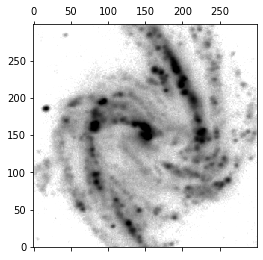

In [12]:
# Get the FITS file (which is index 0 for the NUV image or index=2 for the FUV image)
from pylab import figure, cm
from matplotlib.colors import LogNorm
plt.matshow(dataobj[0].data, origin='lower', cmap=cm.gray_r, norm=LogNorm(vmin=0.005, vmax=0.3))

Hint: Repeat steps for X-ray image. (Note: Ideally, we would find an image in the Chandra 'cxc' catalog) 

In [13]:
x_services=vo.regsearch(servicetype='image',keywords=['chandra'], waveband='x-ray')
print(x_services.to_table()['short_name','ivoid'])

 short_name                 ivoid                 
----------- --------------------------------------
        CDA         ivo://cxc.harvard.edu/cda.siap
        CSC         ivo://cxc.harvard.edu/csc.siap
      CSCR1       ivo://cxc.harvard.edu/cscr1.siap
      CSCR2       ivo://cxc.harvard.edu/cscr2.siap
    Chandra          ivo://nasa.heasarc/chanmaster
GOODSACISFB ivo://nasa.heasarc/skyview/goodsacisfb


In [14]:
## Do an image search for NGC 1365 in the X-ray CDA service found above
xim_table=x_services[0].search(pos=pos,size=0.2)
## Some of these are FITS and some JPEG.  Look at the columns:
print( xim_table.to_table().columns )
first_fits_image_row = [x for x in xim_table if 'image/fits' in x.format][0] 

<TableColumns names=('name','instrument','date_obs','ra','dec','naxis','imgscale','imgfmt','accref','filesize','obsid')>


(460.0, 560.0)

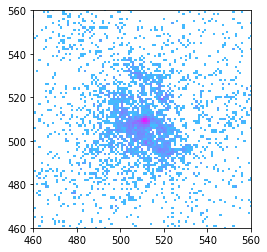

In [15]:
## Create an image from the first FITS file (index=1) by downloading:
## See above for options
#xhdu_list=first_fits_image_row.getdataobj()
file_name = download_file(first_fits_image_row.getdataurl(),cache=True)
xhdu_list=fits.open(file_name)


plt.imshow(xhdu_list[0].data, origin='lower', cmap='cool', norm=LogNorm(vmin=0.1, vmax=500.))
plt.xlim(460, 560)
plt.ylim(460, 560)


### Step 3: Make a spectrum: 

#### Find what Chandra spectral observations exist already for this source. 
Hint: try searching for X-ray spectral data tables using the registry query

In [16]:
# Use the TAP protocol to list services that contain X-ray spectral data
xsp_services=vo.regsearch(servicetype='ssa',waveband='x-ray')
xsp_services.to_table()['short_name','ivoid','waveband']

short_name,ivoid,waveband
object,object,object
Chandra,ivo://nasa.heasarc/chanmaster,x-ray
INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,gamma-ray#x-ray
NED/SED,ivo://ned.ipac/sed_data_near_position,radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray
HEAVENS @ ISDC,ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,x-ray#gamma-ray


Hint 2: Take a look at what data exist for our candidate, NGC 1365.

In [17]:
spec_tables=xsp_services[0].search(pos=pos,radius=0.2,verbose=True)
spec_tables.to_table()

obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_coord_obs,SSA_ra,SSA_dec,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
object,object,object,float64,float64,float64,object,object,float64,object,object,int32,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64
13921,archived,NGC 1365,53.40167,-36.14028,56029.0272,ACIS-S,HETG,110050,GO,Reeves,56398,56029.0271643518,56029.68170909219,56030.335490666206,110050.0,--,53.40167,-36.14028,acisf13921N001_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao13/cat7/13921/primary/acisf13921N001_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
13920,archived,NGC 1365,53.40167,-36.14028,56026.4065,ACIS-S,HETG,90040,GO,Reeves,56398,56026.4065162037,56026.94252101314,56027.47776322905,90040.0,--,53.40167,-36.14028,acisf13920N001_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao13/cat7/13920/primary/acisf13920N001_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


Hint 3: Download the data to make a spectrum. Note: you might end here and use Xspec to plot and model the spectrum. Or ... you can also try to take a quick look at the spectrum. 

In [18]:
#  Get it and look at it:
#hdu_list=spec_tables[0].getdataobj()
file_name = download_file(spec_tables[0].getdataurl(),cache=True)
hdu_list=fits.open(file_name)

spectra=hdu_list[1].data
print(spectra.columns)
print(len(spectra))

ColDefs(
    name = 'SPEC_NUM'; format = '1I'; null = 0
    name = 'TG_M'; format = '1I'; null = 99
    name = 'TG_PART'; format = '1I'
    name = 'TG_SRCID'; format = '1I'; null = 0
    name = 'X'; format = '1E'; unit = 'pixel'
    name = 'Y'; format = '1E'; unit = 'pixel'
    name = 'CHANNEL'; format = '8192I'; null = 0
    name = 'COUNTS'; format = '8192I'; unit = 'count'; null = -1
    name = 'STAT_ERR'; format = '8192E'; unit = 'count'
    name = 'BACKGROUND_UP'; format = '8192I'; unit = 'count'; null = -1
    name = 'BACKGROUND_DOWN'; format = '8192I'; unit = 'count'; null = -1
    name = 'BIN_LO'; format = '8192D'; unit = 'angstrom'
    name = 'BIN_HI'; format = '8192D'; unit = 'angstrom'
)
12


In [19]:
## Or write it to disk
import os
if not os.path.isdir('downloads'):
    os.makedirs("downloads")
fname=spec_tables[0].make_dataset_filename()
#  Known issue where the suffix is incorrect:
fname=fname.replace('None','fits')
with open('downloads/{}'.format(fname),'wb') as outfile:
    outfile.write(spec_tables[0].getdataset().read())

Extension: Making a "quick look" spectrum. For our purposes, the 1st order of the HEG grating data would be sufficient.

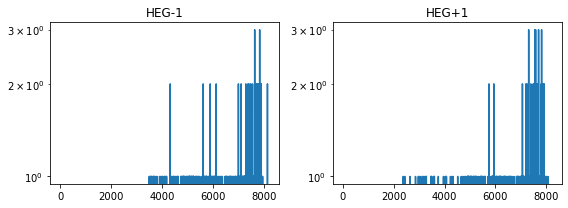

In [20]:
j=1
for i in range(len(spectra)):
    matplotlib.rcParams['figure.figsize'] = (8, 3)
    if abs(spectra['TG_M'][i]) == 1 and (spectra['TG_PART'][i]) == 1:
        ax=plt.subplot(1,2,j)
        pha = plt.plot( spectra['CHANNEL'][i],spectra['COUNTS'][i])
        ax.set_yscale('log')
        if spectra['TG_PART'][i] == 1:
            instr='HEG'
        ax.set_title("{grating}{order:+d}".format(grating=instr, order=spectra['TG_M'][i]))
        plt.tight_layout()
        j=j+1


This can then be analyzed in your favorite spectral analysis tool, e.g., [pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).  (For the winter 2018 AAS workshop, we demonstrated this in a [notebook](https://github.com/NASA-NAVO/aas_workshop_2018/blob/master/heasarc/heasarc_Spectral_Access.ipynb) that you can consult for how to use pyXspec, but the pyXspec documentation will have more information.) 

Congratulations! You have completed this notebook exercise.